In [1]:
import numpy as np
import librosa
from librosa import display
import os
import matplotlib.pyplot as plt
import sklearn.svm

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import IPython.display as ipd
import scipy as sp
from tqdm import tqdm

In [2]:
#DA AGGIUNGERE
audio, fs = librosa.load('inputs/Distortion/test/B11-28100-4411-06241.wav', sr=None)
audio_len = len(audio)
n_frame = int(np.ceil((audio_len-512)/512) + 1)
n_frame

173

In [3]:
classes = ['Distortion', 'Tremolo', 'NoFX']

# DA CAMBIARE
n_centroids = 173


dict_train_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []}

for c in tqdm(classes):
    train_root = 'inputs/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_centroids))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        audio = audio/np.max(np.absolute(audio))
        centroids = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        train_features[index, :] = centroids
        

    dict_train_features[c] = train_features    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.38s/it]


In [4]:
#for cents in dict_train_features["Distortion"]:
    #fig = plt.figure(figsize=(16, 6))
    #plt.plot(np.arange(n_centroids), np.transpose(cents))

In [5]:
#for cents in dict_train_features["Tremolo"]:
    #fig = plt.figure(figsize=(16, 6))
    #plt.plot(np.arange(n_centroids), np.transpose(cents))

In [6]:
dict_test_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []}

for c in tqdm(classes):
    test_root = 'inputs/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_test_samples, n_centroids))
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        audio = audio/np.max(np.absolute(audio))
        centroids = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        test_features[index, :] = centroids
        
    dict_test_features[c] = test_features
    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


In [7]:
class_0 = 'Tremolo'
class_1 = 'NoFX'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]

X_train = np.concatenate((X_train_0, X_train_1), axis=0)

#LABLES OF ZEROS AND ONES CORRESPONDING TO CLASS_0 AND CLASS_1
y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))

y_train = np.concatenate((y_train_0, y_train_1), axis=0)

In [8]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]

X_test = np.concatenate((X_test_0, X_test_1), axis=0)

y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))

y_test = np.concatenate((y_test_0, y_test_1), axis=0)

In [9]:
feat_max = np.max(X_train, axis=0)
feat_min = np.min(X_train, axis=0)
#X_train_normalized = (X_train - feat_min) / (feat_max - feat_min)
#X_test_normalized = (X_test - feat_min) / (feat_max - feat_min)

X_train_normalized = X_train 
X_test_normalized = X_test

In [10]:
SVM_parameters={
    'C': 100,
    'kernel': 'rbf',
    'class_weight': 'balanced', 
}

clf = sklearn.svm.SVC(**SVM_parameters)

In [11]:
clf.fit(X_train_normalized, y_train)

SVC(C=100, class_weight='balanced')

In [12]:
def compute_metrics(gt_labels, predicted_labels):
    TP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 1))
    FP = np.sum(np.logical_and(predicted_labels == 1, gt_labels == 0))
    TN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 0))
    FN = np.sum(np.logical_and(predicted_labels == 0, gt_labels == 1))
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)
    print("Results : \n accuracy = {} \n precision = {} \n recall = {} \n F1 score = {}".format(
        accuracy, precision, recall, F1_score))


In [13]:
y_test_predicted = clf.predict(X_test_normalized)

compute_metrics(y_test, y_test_predicted)

Results : 
 accuracy = 0.9977565900168256 
 precision = 1.0 
 recall = 0.9927927927927928 
 F1 score = 0.996383363471971


In [14]:
class_0 = 'Distortion'
class_1 = 'Tremolo'
class_2 = 'NoFX'

X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

#3 LABLES: 0,1,2
y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2

#y_train = np.concatenate((y_train_class_0, y_train_class_1, y_train_class_1), axis=0)

In [15]:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

In [16]:
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)


In [17]:
SVM_parameters={
    'C': 1000,
    'kernel': 'rbf',
    #'class_weight': 'balanced',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)


In [18]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=1000, probability=True)

In [19]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)

In [20]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [21]:
#MAJORITY VOTING
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

In [22]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [23]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)
print(confusion_matrix(y_test_mc, y_test_predicted_mv, labels=[0,1,2]))

scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

[[1.218e+03 1.900e+01 1.000e+00]
 [4.000e+00 1.224e+03 0.000e+00]
 [7.000e+00 1.000e+00 5.470e+02]]
[[1218   19    1]
 [   4 1224    0]
 [   7    1  547]]


array([1.        , 1.        , 1.        , 0.98571429, 0.96857143])

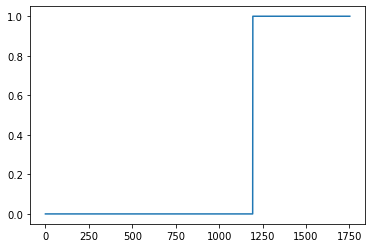

In [24]:
X_train.shape
plt.plot(y_train)

In [25]:
tuned_parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
 ]

scores = ['precision', 'recall']

for score in tqdm(scores):
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_micro' % score
    )
    clf.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
            np.concatenate((y_train_1, y_train_2), axis=0))

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

# Tuning hyper-parameters for precision



C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs

Best parameters set found on development set:

{'C': 1000, 'kernel': 'rbf'}

Grid scores on development set:

0.759 (+/-0.121) for {'C': 1, 'kernel': 'linear'}
0.735 (+/-0.073) for {'C': 10, 'kernel': 'linear'}
0.710 (+/-0.103) for {'C': 100, 'kernel': 'linear'}
0.689 (+/-0.085) for {'C': 1000, 'kernel': 'linear'}
0.916 (+/-0.044) for {'C': 1, 'kernel': 'rbf'}
0.984 (+/-0.035) for {'C': 10, 'kernel': 'rbf'}
0.993 (+/-0.019) for {'C': 100, 'kernel': 'rbf'}
0.993 (+/-0.016) for {'C': 1000, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1228
         1.0       0.06      0.15      0.09       555
         2.0       0.00      0.00      0.00         0

    accuracy                           0.05      1783
   macro avg       0.02      0.05      0.03      1783
weighted avg       0.02    

C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs\CMLS\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\il_gi\miniconda3\envs

Best parameters set found on development set:

{'C': 1000, 'kernel': 'rbf'}

Grid scores on development set:

0.759 (+/-0.121) for {'C': 1, 'kernel': 'linear'}
0.735 (+/-0.073) for {'C': 10, 'kernel': 'linear'}
0.710 (+/-0.103) for {'C': 100, 'kernel': 'linear'}
0.689 (+/-0.085) for {'C': 1000, 'kernel': 'linear'}
0.916 (+/-0.044) for {'C': 1, 'kernel': 'rbf'}
0.984 (+/-0.035) for {'C': 10, 'kernel': 'rbf'}
0.993 (+/-0.019) for {'C': 100, 'kernel': 'rbf'}
0.993 (+/-0.016) for {'C': 1000, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1228
         1.0       0.06      0.15      0.09       555
         2.0       0.00      0.00      0.00         0

    accuracy                           0.05      1783
   macro avg       0.02      0.05      0.03      1783
weighted avg       0.02    